In [1]:
import sys
sys.path.append("C:\ZSOMBI\OneDrive\PoPy")
sys.path.append("/Users/zsombi/OneDrive/PoPy")

import pandas as pd

from popy.io_tools import *
from popy.behavior_data_tools import *
from popy.neural_data_tools import time_normalize_session, scale_neural_data, remove_low_fr_neurons, remove_trunctuated_neurons
from popy.decoders import *
from popy.plotting_tools import *
from decoder_tools import *
from popy.dim_reduction import *
import popy.config as cfg


def plot_trajectory_fb_value(X, y, ep_times, label_name=None, ax=None, title=None, savedir=None):
    # colors from matplotlib tab
    colors = {label: color for label, color in zip(np.unique(y), list(mcolors.TABLEAU_COLORS.keys()))}
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    if title:
        ax.set_title(title)
        
    for i, y_curr in enumerate(np.unique(y)):
        data = X[y==y_curr]  # get data for current label

        # mean and std
        mean = data.mean(axis=0)
        std = data.std(axis=0)

        # plot mean trajectory with std
        ax.plot(mean, label=y_curr, color=colors[y_curr])
        ax.fill_between(np.arange(len(mean)), mean-std, mean+std, alpha=.2, color=colors[y_curr])

    # plot epoch times and label x axis
    for label, time in ep_times.items():
        ax.axvline(time, color='grey' if label != 'fb' else 'tab:red', linestyle='dashed', alpha=.5, linewidth=1)
    times_ticks = list(ep_times.values())[:-1]
    labels_ticks = list(ep_times.keys())[:-1]
    ax.set_xticks(times_ticks)
    ax.set_xticklabels(labels_ticks)

    ax.axhline(0, color='grey', alpha=0.5)  # plot zero line
    ax.set_xlabel('time')
    ax.set_ylabel('activity')

    # legend next to figure
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title=label_name if label_name else None)

    if savedir:
        plt.savefig(savedir, bbox_inches='tight')

def transform_data(session_data, neural_data_area, mode='full', cut_time=None,
                     behav_condition=None):
    
    pca = fit_model(session_data, neural_data_area, mode=mode, cut_time=cut_time)

    PCA_data = neural_data_area.copy(data=pca.transform(neural_data_area.T).T)
    PCA_data.attrs = neural_data_area.attrs
    # change "unit" coordinate to "PC"
    PCA_data = PCA_data.rename({'unit': 'component'})
    # add PC number as coordinate
    PCA_data['component'] = np.arange(PCA_data.shape[0])
    # add explained variance to component dimension
    PCA_data = PCA_data.assign_coords(expl_var=("component", pca.explained_variance_ratio_))

    return PCA_data

Using OFFICE_mac path
Inserm drive is not accessible


# Get data

In [2]:
monkey, session = 'ka', '210322'

session_data_full = load_behavior()
session_data = session_data_full[(session_data_full['monkey'] == monkey) & (session_data_full['session'] == session)]
session_data = add_value_function(session_data)  # add action value
# session_data['value_function'] = session_data['value_function'].shift(-1)
session_data = add_RPE(session_data)  # add reward pred         iction error
session_data['value_function_digit'] = np.digitize(session_data['value_function'], bins=[0, 0.25, 0.5, .75, 1])
session_data = session_data.dropna()

neural_data = load_neural_data(monkey, session)
neural_data = remove_trunctuated_neurons(neural_data, delay_limit=10)
# remove low_firing units
neural_data = remove_low_fr_neurons(neural_data, 1)
# normalize neural data in time
neural_data = time_normalize_session(neural_data)
neural_data = scale_neural_data(neural_data)


adding history of feedback column, but if the data is pooled across sessions, make sure to add the history before pooling data to keep the order of time!
Loading rates data
Removed 0 units with no spikes.
Removed 12/47 units with truncated data.
Removed 0 units with mean firing rate below 1 Hz.
Normalizing firing rates (in time)...


100%|██████████| 425/425 [00:18<00:00, 22.52it/s]
/Users/zsombi/Library/CloudStorage/OneDrive-Personal/envs/popy1/lib/python3.10/site-packages/xarray/core/concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


Removed 0 interrupted trials.
Very long epochs: 1 epochs longer than 10s.


In [3]:
neural_data

<xarray.DataArray (unit: 35, time: 318750)>
array([[-0.8969108 , -0.33001986,  1.1196437 , ..., -0.3040289 ,
        -0.32859004, -0.37291583],
       [-0.60241735, -0.6361379 , -0.6361379 , ..., -0.6361379 ,
        -0.6361379 , -0.6361379 ],
       [-0.97974426, -0.64020103, -0.9786724 , ..., -0.28213122,
        -0.1610805 , -0.05669808],
       ...,
       [ 2.0617785 , -0.46192116, -0.46192116, ..., -0.46192116,
        -0.46192116, -0.46190614],
       [-0.42625615, -0.63698757, -0.63698757, ..., -0.63698757,
        -0.63698757, -0.63698757],
       [ 0.8501729 , -0.73562235,  0.24931937, ..., -0.7293427 ,
        -0.72455686, -0.7157679 ]], dtype=float32)
Coordinates:
    trial_id          (time) float64 0.0 0.0 0.0 0.0 ... 424.0 424.0 424.0 424.0
    epoch_id          (time) float64 0.0 0.0 0.0 0.0 0.0 ... 5.0 5.0 5.0 5.0 5.0
  * unit              (unit) object 'LPFC_03_01' 'LPFC_04_03' ... 'MCC_16_01'
    area              (unit) object 'LPFC' 'LPFC' 'LPFC' ... 'MCC' 'MCC' 'MCC'
    unit_id_original  (unit) int32 65 8 68 9 16 69 28 ... 46 48 49 53 52 61 58
    channel           (unit) int32 3 4 4 4 5 5 6 6 6 ... 11 12 12 13 13 14 16 16
  * time              (time) float64 9.8 10.23 10.65 ... 3.279e+03 3.279e+03
Attributes:
    bin_size:  0.01

Match neural and behav trials

In [4]:
# only shared ids
neural_trials = neural_data.trial_id.values
behav_trials = session_data.trial_id.values
shared_trials = np.intersect1d(neural_trials, behav_trials)

neural_data = neural_data[:, neural_data.trial_id.isin(shared_trials)]
session_data = session_data[session_data.trial_id.isin(shared_trials)]

# PCA method

In [28]:
area = 'MCC'

neural_data_area = neural_data[neural_data.area==area]
#neural_data_area = neural_data

#modes = ['full', 'mean', 'full_cut', 'mean_cut', 'behav']
pca_mode = 'full_cut'
cut_time = ['before_feedback', 'after_feedback', 'decision'][2]
condition_of_interest = 'value_function_digit'

# run PCA
PCA_data = transform_data(session_data, neural_data_area, mode=pca_mode, cut_time=cut_time)

Number of trials in neural but not in behav: 0
Number of trials in behav but not in neural: 0


In [29]:
neural_data_area.shape

(16, 312750)

In [30]:
PCA_data

<xarray.DataArray (component: 16, time: 312750)>
array([[-1.787359  , -1.6163396 , -1.6016554 , ..., -1.4160953 ,
        -1.4857293 , -1.5478718 ],
       [-1.0818402 , -1.2238774 , -1.3252844 , ...,  0.2552695 ,
         0.2110299 ,  0.15417144],
       [-0.3803952 , -0.23967414, -0.10830045, ..., -0.79760766,
        -0.9049966 , -1.0458294 ],
       ...,
       [-1.3070875 , -1.5733378 , -1.6471698 , ..., -0.6914613 ,
        -0.8973668 , -1.0928316 ],
       [-0.4776497 , -0.59082025, -0.60249776, ...,  0.50876504,
         0.75749075,  1.0346735 ],
       [-0.23573282, -0.49163693, -0.74586934, ..., -0.69123507,
        -0.7764201 , -0.83019006]], dtype=float32)
Coordinates:
    trial_id          (time) float64 8.0 8.0 8.0 8.0 ... 424.0 424.0 424.0 424.0
    epoch_id          (time) float64 0.0 0.0 0.0 0.0 0.0 ... 5.0 5.0 5.0 5.0 5.0
  * component         (component) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
    area              (component) object 'MCC' 'MCC' 'MCC' ... 'MCC' 'MCC' 'MCC'
    unit_id_original  (component) int32 26 28 66 33 32 30 ... 48 49 53 52 61 58
    channel           (component) int32 6 7 7 8 8 8 9 10 11 12 12 13 13 14 16 16
  * time              (time) float64 118.4 118.4 118.4 ... 3.279e+03 3.279e+03
    expl_var          (component) float32 0.2247 0.1154 ... 0.02978 0.02815
Attributes:
    bin_size:  0.01

## Plot results

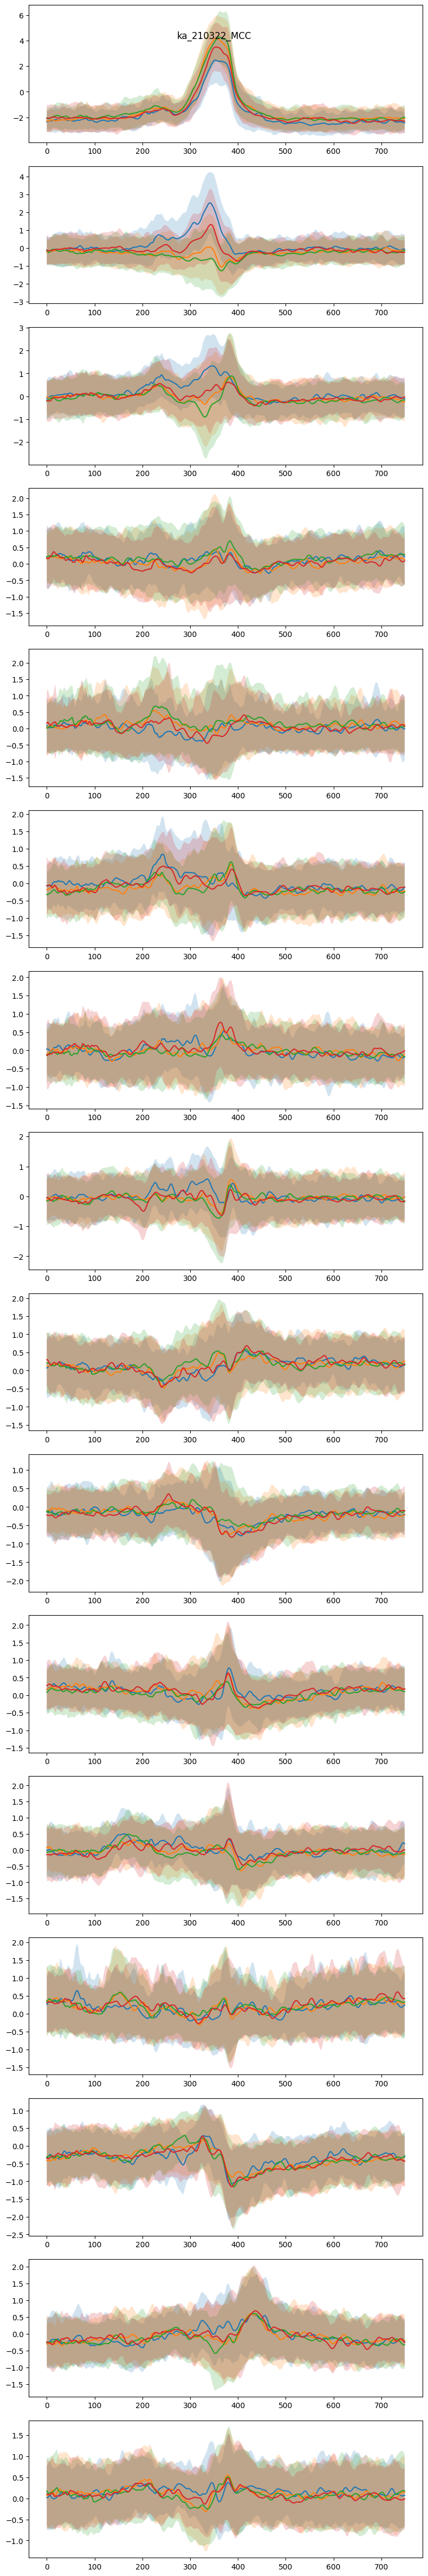

In [8]:
label_name = 'value_function'
y_1 = session_data[label_name].values
# make it categorial: 0-.25, .25-.5, .5-.75, .75-1
y_1 = pd.cut(y_1, bins=[0, .25, .5, .75, 1], labels=[0, 1, 2, 3])

ep_times = get_epoch_lens()
ep_times = {k: v/neural_data.attrs['bin_size'] for k, v in ep_times.items()}

n_pcs = PCA_data.shape[0]
unit_names = PCA_data.component.values

fig, axs = plt.subplots(n_pcs, 1, figsize=(8, 3*n_pcs))
plt.suptitle(f'{monkey}_{session}_{area}')

for pc in range(n_pcs):
    ax = axs[pc]
    # get data for pc
    PCA_data_temp = PCA_data[pc, :]
    # create dataset of shape (n_trials, time_in_trial, n_components) from neural data format of shape (n_components, absoulte_time)
    pca_data_np = np.array([PCA_data_temp[np.where(PCA_data_temp.trial_id.data == trial)[0]] for trial in shared_trials])
    
    for y_unique in y_1.unique():
        # get data for current label
        data = pca_data_np[y_1==y_unique]
        # mean and std
        mean = data.mean(axis=0)
        std = data.std(axis=0)
        # plot mean trajectory with std
        ax.plot(mean, label=y_unique,)
        ax.fill_between(np.arange(len(mean)), mean-std, mean+std, alpha=.2)

    # explain variance
    #var = PCA_data_temp.expl_var.data

    '''plot_trajectory_fb_value(pca_data_np, y_1, label_name=label_name, ep_times=ep_times, ax=ax,
                             #title=f'PC {pc+1}, explained variance {var:.2f}')
                             title=f'unit {pc+1}, {unit_names[pc]}')'''
    
plt.tight_layout()

In [31]:
# get data for pc
PCA_data_temp = PCA_data

# create dataset
pca_data_np = np.array([PCA_data_temp[:, np.where(PCA_data_temp.trial_id.data == trial)[0]] for trial in shared_trials])

pca_data_np.shape

(417, 16, 750)

In [33]:
cat_1.shape

(2, 750)

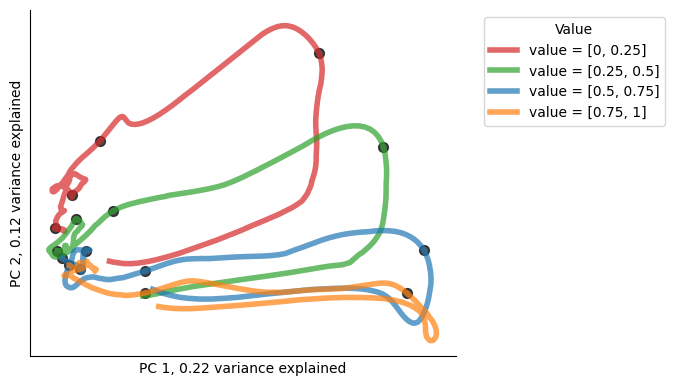

In [67]:
# plot 1st and 2nd trajectory in 2D

fig, ax = plt.subplots(1, 1, figsize=(5.5, 4.5))

#condition, categorized as 0=0-0.33, 1=0.33-0.66, 2=0.66-1
y_2 = session_data.value_function.values
y_2_category = np.digitize(y_2, bins=[0, 0.25, 0.5, .75, 1])

cat_1 = pca_data_np[y_2_category==1, :, 200:400].mean(0)
cat_2 = pca_data_np[y_2_category==2, :,200:400].mean(0)
cat_3 = pca_data_np[y_2_category==3, :,200:400].mean(0)
cat_4 = pca_data_np[y_2_category==4, :, 200:400].mean(0)

# plot in 3d, arrow at end of trajectory, color by value
colors = {0: 'red', 1: 'green', 2: 'blue', 3: 'orange'}
ax.plot(cat_1[0, :], cat_1[1, :], color='tab:red', label='value = [0, 0.25]', markersize=5, linewidth=4, alpha=0.7)
ax.plot(cat_2[0, :], cat_2[1, :], color='tab:green', label='value = [0.25, 0.5]', markersize=5, linewidth=4, alpha=0.7)
ax.plot(cat_3[0, :], cat_3[1, :], color='tab:blue',  label='value = [0.5, 0.75]', markersize=5, linewidth=4, alpha=0.7)
ax.plot(cat_4[0, :], cat_4[1, :], color='tab:orange', label='value = [0.75, 1]', markersize=5, linewidth=4, alpha=0.7)

# mark at 200, 250, 300, 350 bin
for i in range(0, 200, 50):
    ax.scatter(cat_1[0, i], cat_1[1, i], color='black', s=50, alpha=0.7)
    ax.scatter(cat_2[0, i], cat_2[1, i], color='black', s=50, alpha=0.7)
    ax.scatter(cat_3[0, i], cat_3[1, i], color='black', s=50, alpha=0.7)
    ax.scatter(cat_4[0, i], cat_4[1, i], color='black', s=50, alpha=0.7)

# hide top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# hide x and y numbering
ax.set_xticks([])
ax.set_yticks([])

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Value')
ax.set_xlabel(f'PC {1}, {PCA_data[0].expl_var.data:.2f} variance explained')
ax.set_ylabel(f'PC {2}, {PCA_data[1].expl_var.data:.2f} variance explained')

# save figure
plt.savefig(f'/Users/zsombi/Library/CloudStorage/OneDrive-Personal/PoPy/figs/{monkey}_{session}_{area}_low_dim_trajectory.svg', bbox_inches='tight')

NameError: name 'y_1' is not defined

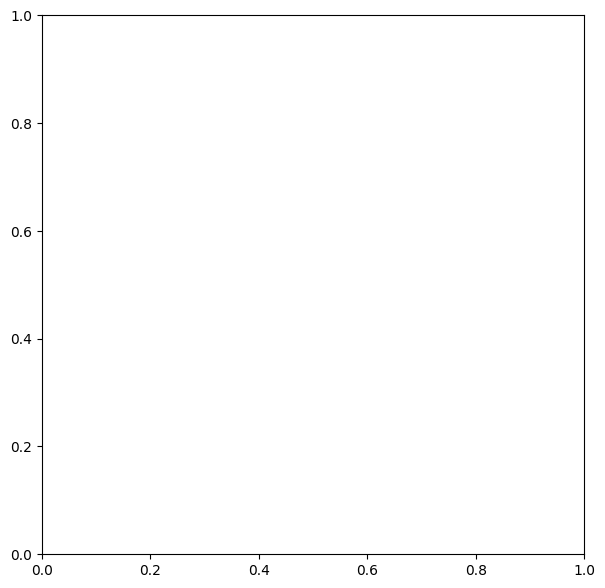

In [ ]:
# plot 1st and 2nd trajectory in 2D
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

# get y_1 trials
cat_1 = pca_data_np[y_1==0, :, :].mean(0)
cat_2 = pca_data_np[y_1==1, :, :].mean(0)


ax.plot(cat_1[2, 100:450], cat_1[3, 100:450], color='red', marker='o', alpha=0.5, label='Feedback negative')
ax.plot(cat_2[2, 100:450], cat_2[3, 100:450], color='green', marker='o', alpha=0.5, label='Feedback positive')

# star at 350
ax.plot(cat_1[2, 350], cat_1[3, 350], color='black', marker='*', markersize=20, label='Feedback onset')
ax.plot(cat_2[2, 350], cat_2[3, 350], color='black', marker='*', markersize=20)

# hide top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# title
ax.set_title('Low-dimensional trajectory of neural activity encoding Feedback')

# hide x and y numbering
ax.set_xticks([])
ax.set_yticks([])

ax.legend()
ax.set_xlabel('PC 2, var=0.07')
ax.set_ylabel('PC 3, var=0.07')